<a href="https://colab.research.google.com/github/arturbernardo/eficacia_vacina_covid19/blob/main/eficiencia_vacinas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget -U "Mozilla" -O mortalidade_2021.csv https://s3.sa-east-1.amazonaws.com/ckan.saude.gov.br/SIM/Mortalidade_Geral_2021.csv

--2024-02-15 22:51:11--  https://s3.sa-east-1.amazonaws.com/ckan.saude.gov.br/SIM/Mortalidade_Geral_2021.csv
Resolving s3.sa-east-1.amazonaws.com (s3.sa-east-1.amazonaws.com)... 52.95.164.78, 52.95.163.70, 52.95.164.92, ...
Connecting to s3.sa-east-1.amazonaws.com (s3.sa-east-1.amazonaws.com)|52.95.164.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 632732700 (603M) [text/csv]
Saving to: ‘mortalidade_2021.csv’

mortalidade_2021.cs 100%[===================>] 603.42M  8.80MB/s    in 71s     

2024-02-15 22:52:24 (8.51 MB/s) - ‘mortalidade_2021.csv’ saved [632732700/632732700]



In [2]:
!pip install datetime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.1/247.1 kB 8.1 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

In [4]:
#@title Convert data

def converter_data(data):
    data_str = str(int(data)).zfill(8)

    dia = int(data_str[:2])
    mes = int(data_str[2:4])
    ano = int(data_str[4:])

    return pd.to_datetime(f"{ano}-{mes}-{dia}")

converter_data(18061962.0)

Timestamp('1962-06-18 00:00:00')

In [5]:
path = "/content/mortalidade_2021.csv"

In [6]:
mortalidade_2021 = pd.read_csv(path, engine="python", sep=";",
                 converters={
                     "DTNASC": converter_data,
                     "DTOBITO": converter_data
                     })

In [ ]:
mortalidade_2021['IDADE'] = (mortalidade_2021['DTOBITO'] - mortalidade_2021['DTNASC']).astype('<m8[Y]')
mortes_covid = mortalidade_2021[mortalidade_2021['CAUSABAS'].str.contains('B34')]
mortes_covid['IDADE'] = (mortes_covid['DTOBITO'] - mortes_covid['DTNASC']).astype('<m8[Y]')

mortes_c19_agg_data = mortes_covid.groupby('DTOBITO')
mortes_c19_agg_dia_idade = mortes_covid.groupby(['DTOBITO', 'IDADE']).size().rename('NUM_MORTES').to_frame()

mortalidade_dia = mortes_c19_agg_dia_idade.groupby(level=0).sum()
mortalidade_dia['MEDIA_MOVEL'] = mortalidade_dia['NUM_MORTES'].rolling(window=14).mean()


In [42]:
filtro_idade = mortes_covid[mortes_covid['IDADE'] >= 80]

maior_80 = filtro_idade.groupby('DTOBITO')['IDADE'].size().rename('NUM_MORTES').to_frame()
maior_80['MEDIA_MOVEL'] = maior_80['NUM_MORTES'].rolling(window=14).mean()

In [43]:
data_to_plot = []
percentual_to_plot = []
window_size = 3

for index, todos, m80 in zip(mortalidade_dia.index, mortalidade_dia.MEDIA_MOVEL, maior_80.MEDIA_MOVEL):
    percentual = (m80 * 100) / todos
    data_to_plot.append(index)
    percentual_to_plot.append(percentual)

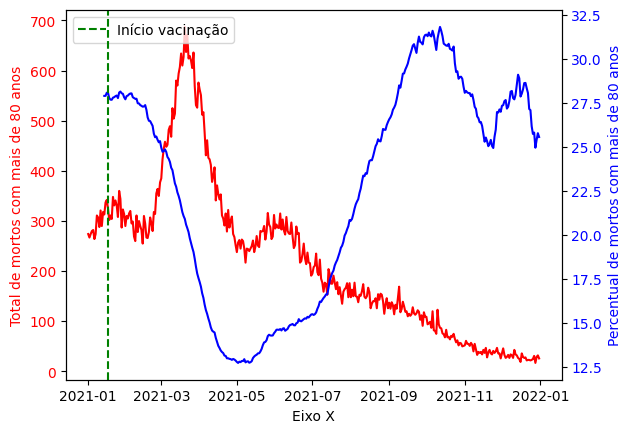

In [44]:
# Do total de mortos, o percentual correspondente a maiores de 80 anos caiu de ~= 28% para ~= 13%.
# No mesmo período o número de idosos vitimados pela pandêmia atingiu um pico de 700 por dia.

total_mortos_to_plot = []
for m80 in maior_80.NUM_MORTES:
    total_mortos_to_plot.append(m80)

fig, ax1 = plt.subplots()
ax1.plot(data_to_plot, total_mortos_to_plot, color='red')
ax1.set_xlabel('Eixo X')
ax1.set_ylabel('Total de mortos com mais de 80 anos', color='red')
ax1.tick_params(axis='y', labelcolor='red')

ax2 = ax1.twinx()
ax2.plot(data_to_plot, percentual_to_plot, color='blue')
ax2.set_ylabel('Percentual de mortos com mais de 80 anos', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

data_vertical = pd.Timestamp('2021-01-17')
plt.axvline(x=data_vertical, color='green', linestyle='--', label='Início vacinação')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')


plt.show()

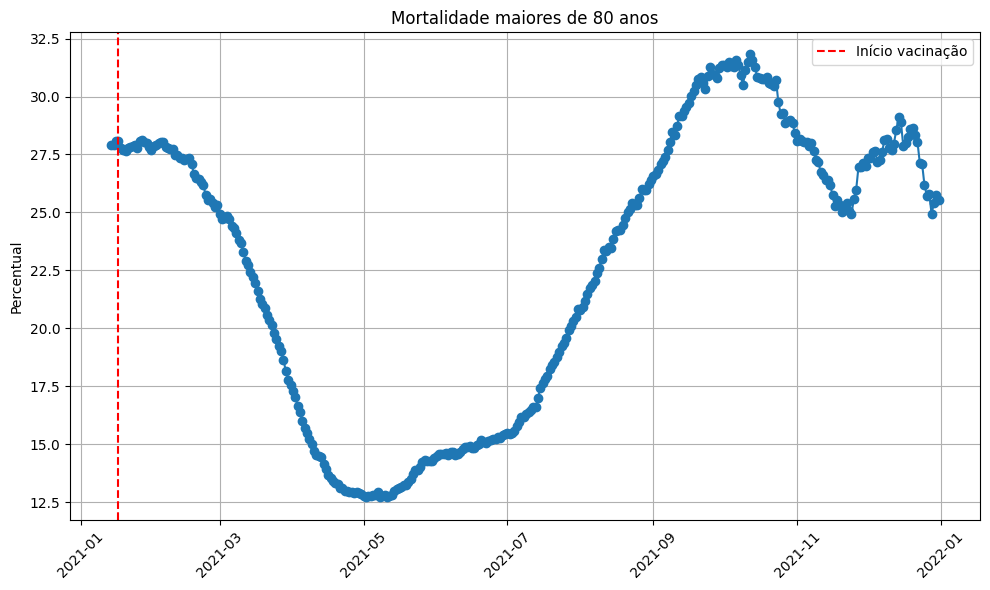

In [45]:
# Primeira pessoa foi vacinada no Brasil dia 17/01
# O foco eram pessoas com comorbidades, profissionais da saúde e idosos com mais de 90 anos.
# A vacinação para maiores de 80 se estendeu por fevereiro
# https://g1.globo.com/sp/sao-paulo/noticia/2021/01/17/apos-aprovacao-da-anvisa-governo-de-sp-aplica-1a-dose-da-coronavac-antes-do-inicio-do-plano-nacional-de-vacinacao.ghtml
# https://noticias.uol.com.br/saude/ultimas-noticias/redacao/2021/02/12/falta-vacinas-atraso-da-vacinacao-em-sao-paulo.htm

plt.figure(figsize=(10, 6))
plt.plot(data_to_plot[2:], percentual_to_plot[2:], marker='o', linestyle='-')

plt.ylabel('Percentual')
plt.title('Mortalidade maiores de 80 anos')

data_vertical = pd.Timestamp('2021-01-17')
plt.axvline(x=data_vertical, color='red', linestyle='--', label='Início vacinação')
plt.legend()

plt.xticks(rotation=45)

plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
filtro_idade = mortes_covid[(mortes_covid['IDADE'] >= 70) & (mortes_covid['IDADE'] < 80)]

maior_70 = filtro_idade.groupby('DTOBITO')['IDADE'].size().rename('NUM_MORTES').to_frame()
maior_70['MEDIA_MOVEL'] = maior_70['NUM_MORTES'].rolling(window=14).mean()

In [22]:
data_to_plot = []
percentual_to_plot = []
window_size = 3

for index, todos, m70 in zip(mortalidade_dia.index, mortalidade_dia.MEDIA_MOVEL, maior_70.MEDIA_MOVEL):
    percentual = (m70 * 100) / todos
    data_to_plot.append(index)
    percentual_to_plot.append(percentual)

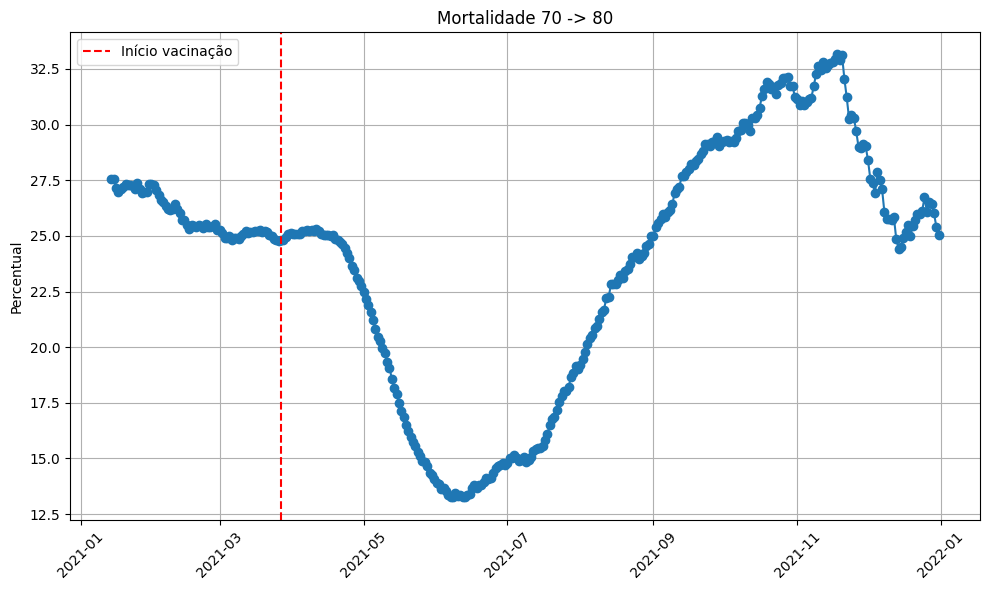

In [23]:
# Maiores de 70 anos
# https://www2.ufjf.br/noticias/2021/03/30/idosos-anos-ou-mais-comecam-a-ser-vacinados-nesta-5a-na-ufjf/
plt.figure(figsize=(10, 6))
plt.plot(data_to_plot[2:], percentual_to_plot[2:], marker='o', linestyle='-')

plt.ylabel('Percentual')
plt.title('Mortalidade 70 -> 80')

data_vertical = pd.Timestamp('2021-03-27')
plt.axvline(x=data_vertical, color='red', linestyle='--', label='Início vacinação')
plt.legend()

plt.xticks(rotation=45)

plt.grid(True)
plt.tight_layout()
plt.show()

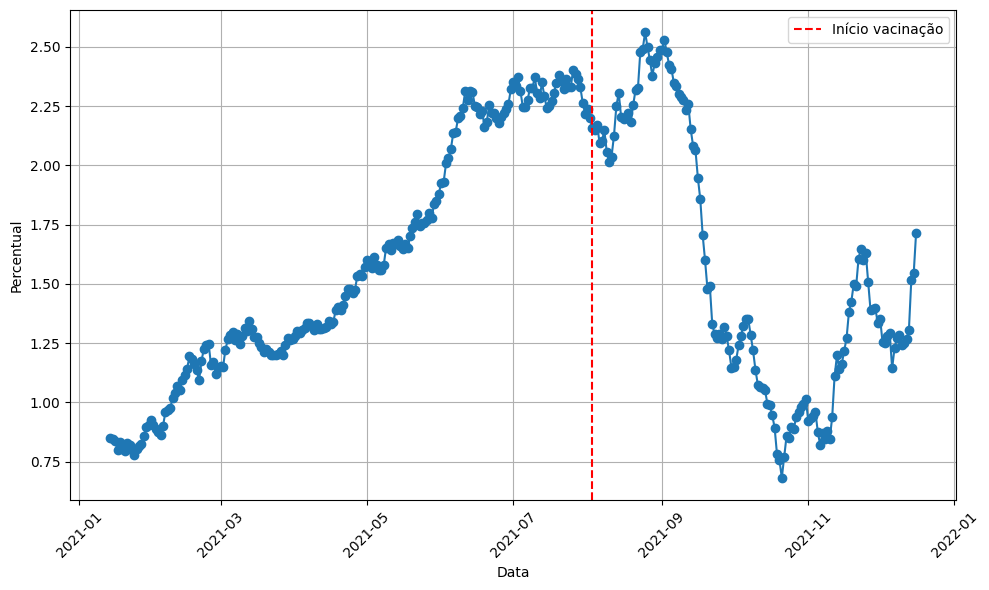

In [37]:
# Menos de 30
# As primeiras pessoas com 30 começaram a ser vacinadas no início de agosto.
# https://www.saude.df.gov.br/web/guest/w/tem-30-anos-ou-mais-veja-onde-se-vacinar-contra-a-covid-19#:~:text=Veja%20onde%20se%20vacinar%20contra%20a%20covid%2D19,-Vacina%C3%A7%C3%A3o%20ocorre%20em&text=A%20vacina%C3%A7%C3%A3o%20contra%20a%20covid,mais%20come%C3%A7a%20a%20ser%20vacinado.

filtro_idade = mortes_covid[(mortes_covid['IDADE'] <= 30) & (mortes_covid['IDADE'] >= 20)]

people = filtro_idade.groupby('DTOBITO')['IDADE'].size().rename('NUM_MORTES').to_frame()
people['MEDIA_MOVEL'] = people['NUM_MORTES'].rolling(window=14).mean()

data_to_plot = []
percentual_to_plot = []
window_size = 3

for index, todos, p in zip(mortalidade_dia.index, mortalidade_dia.MEDIA_MOVEL, people.MEDIA_MOVEL):
    percentual = (p * 100) / todos
    data_to_plot.append(index)
    percentual_to_plot.append(percentual)

plt.figure(figsize=(10, 6))
plt.plot(data_to_plot[2:], percentual_to_plot[2:], marker='o', linestyle='-')

plt.xlabel('Data')
plt.ylabel('Percentual')
plt.title('')

data_vertical = pd.Timestamp('2021-08-03')
plt.axvline(x=data_vertical, color='red', linestyle='--', label='Início vacinação')

plt.legend()

plt.xticks(rotation=45)

plt.grid(True)
plt.tight_layout()
plt.show()
